# ABCD - The Simple Case
A very simple ABCD method calculation: Build a dataset, define a cut, and then predict A from B, C, and D. The variables created are totally uncorrelated.

We define ABCD as A in the upper left hand quadrant, B in the lower left hand, C in the upper right hand and D in the lower right hand:

       +----+----+
       |  A |  C |
    v2 +----+----+
       |  B +  D |
       +---------+
           v1
   
 Thus, the ratio is A/B = C/D or A = BC/D.
 
     A: v1 <= xcut & v2 > ycut
     B: v1 <= xcut & v2 <= ycut
     C: v1 > xcut & v2 > ycut
     D: v1 > xcut & v2 <= ycut

## Initalization

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Fot size for titles and axes, default is 10
plt.rc('font', size=14)
from scipy.stats import norm

## Sample Generation

In [2]:
def generate(n):
  sample_np = np.random.rand(n, 2)
  return pd.DataFrame(sample_np, columns=['v1', 'v2'])

In [3]:
sample=generate(10000)

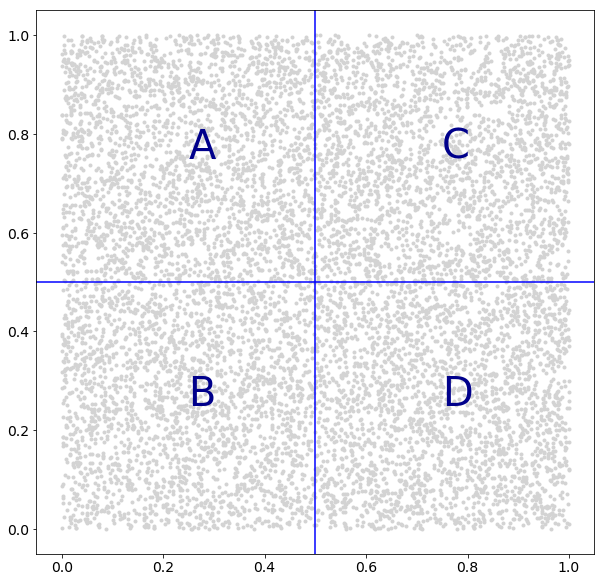

In [4]:
xcut = 0.5
ycut = 0.5
plt.figure(figsize=(10,10))
plt.plot(sample.v1, sample.v2, '.', c='lightgrey');
plt.axvline(ycut, c='blue')
plt.axhline(xcut, c='blue');
for dx,dy, char in zip([-1,-1,+1,+1],[+1,-1,+1,-1], 'ABCD'):
    plt.text(xcut+dx*0.25, ycut+dy*0.25, char, fontsize=40, color='darkblue');

## ABCD Calculation

In [5]:
def calc_ABCD(s, xc, yc):
    # Build lists of true and false for each regions condition
    right = s.v1>xc
    up = s.v2>ycut
    left = ~right
    down = ~up
    nA,nB,nC,nD = [np.sum(z) for z in [left & up, left & down, right & up, right & down]]
    if (nD == 0) | (nA == 0):
        return 0
    pred = nB*nC/nD
    return (nA - pred)/nA

In [6]:
calc_ABCD(sample, xcut, ycut)

0.061807870921648002

## Statstical Error

In [7]:
def ABCD_statistics (nS, xcut, ycut):
    s = generate(nS)
    return calc_ABCD(s, xcut, ycut)

In [8]:
stas = pd.DataFrame([ABCD_statistics(int(1000), xcut, ycut) for i in range(1000)], columns=['FracError'])

In [9]:
mu, std = norm.fit(stas.FracError)

Text(0.5,1,'Fit results: mu = -0.01,  std = 0.13')

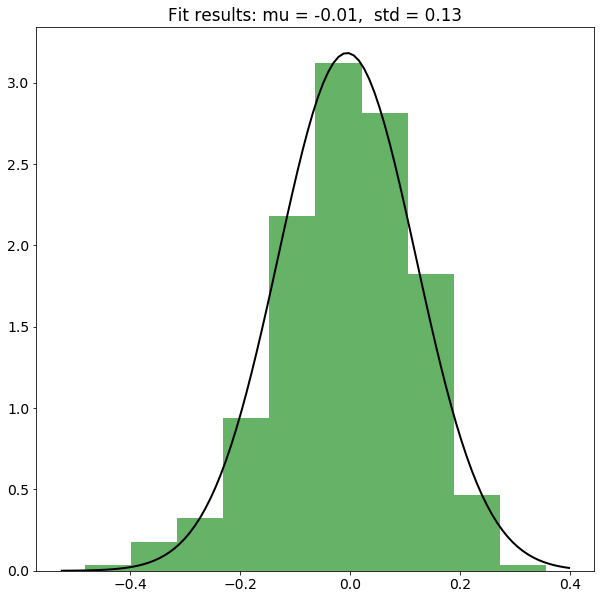

In [10]:
plt.figure(figsize=(10,10))
plt.hist(stas.FracError, normed=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Fit results: mu = {0:.2f},  std = {1:.2f}".format(mu, std))

## Statistical Error and Sample Size

In [11]:
def ABCD_error (nS, nIter, xc, yc):
    stas = pd.DataFrame([ABCD_statistics(nS, xc, yc) for i in range(nIter)], columns=['FracError'])
    mu, std = norm.fit(stas.FracError)
    return std

In [12]:
errors = pd.DataFrame(np.array([(ns, ABCD_error(int(ns), 100, xcut, ycut))
                                for ns in  np.logspace(np.log10(20), 5, 20)
                               ]), 
                      columns=['nSamples', 'Error'])

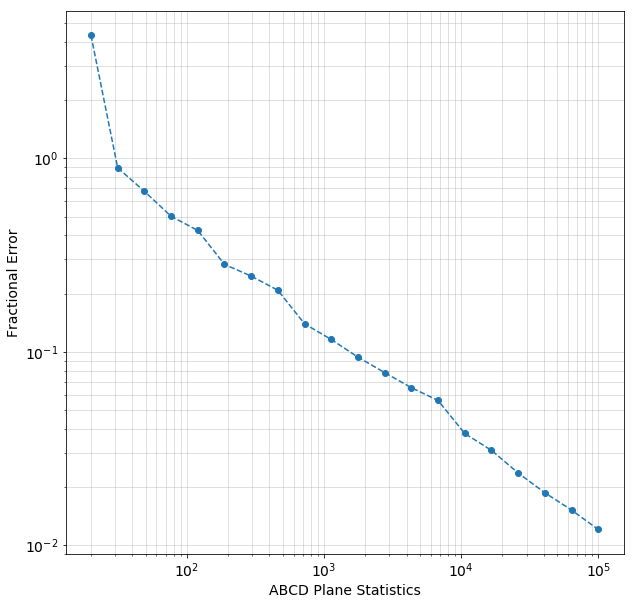

In [13]:
plt.figure(figsize=(10,10))
plt.loglog(errors.nSamples, errors.Error, 'o--')
plt.xlabel("ABCD Plane Statistics")
plt.ylabel("Fractional Error")
plt.grid(alpha=0.5, which='both')

## Covarience of Random Samples
In this notebook, all the samples come from an uncorrelated distribution. Due to the statistical nature - and especially with small n, we always expect there to be some correlation.


First, inspect for sample. The off diagonal elements are what we normally think of as the correlation between the two variables.

In [14]:
np.cov(generate(20), rowvar=False)

array([[ 0.09818222, -0.02854721],
       [-0.02854721,  0.06561291]])

In [15]:
def plot_covar_histo(nSize):
    l = pd.DataFrame(np.array([np.cov(generate(int(nSize)), rowvar=False)[0,1] for i in range(1000)]), columns=['covar'])
    mu,std = norm.fit(l)

    plt.figure(figsize=(10,10))
    plt.hist(l.covar, normed=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Fit results (N={2}): mu = {0:.4f},  std = {1:.4f}".format(mu, std, nSize))

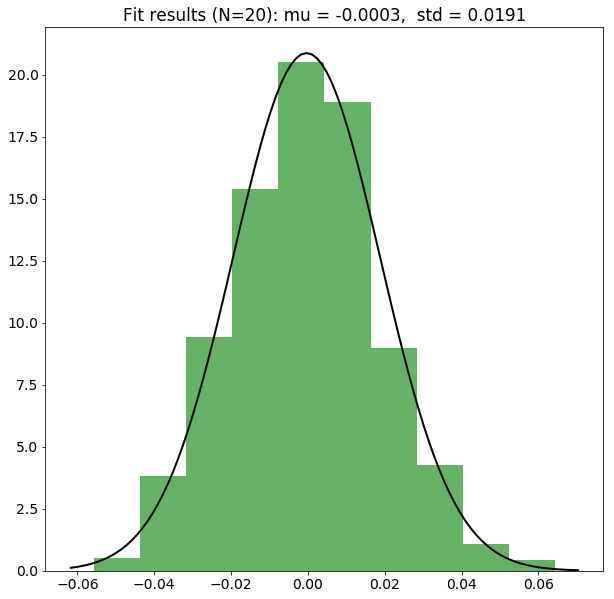

In [16]:
plot_covar_histo(20)

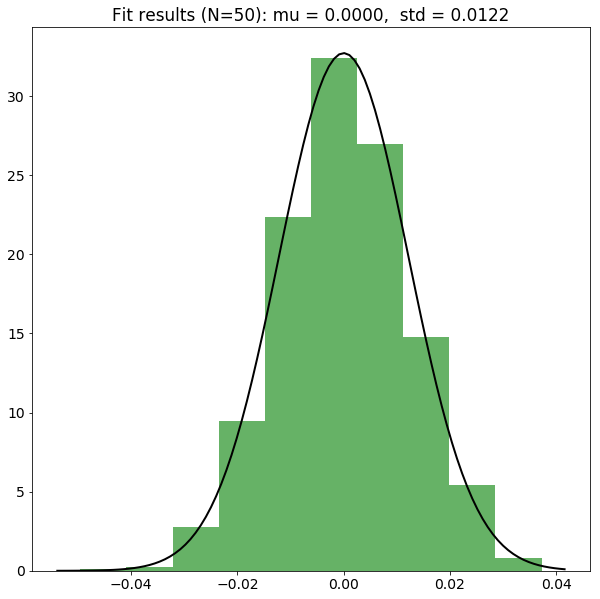

In [17]:
plot_covar_histo(50)

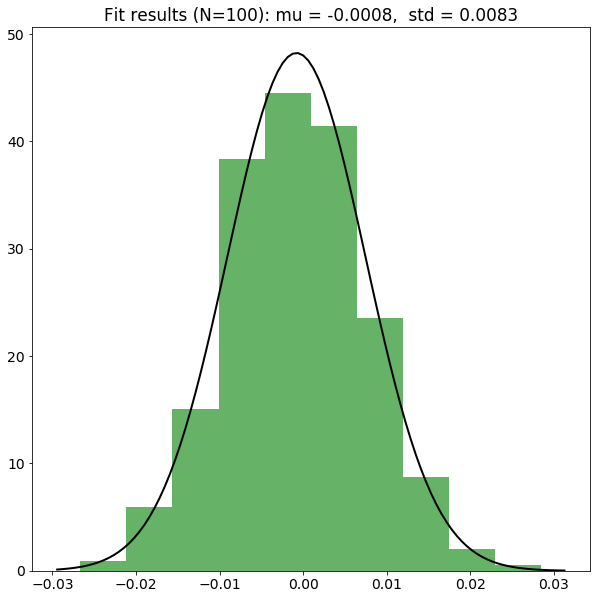

In [18]:
plot_covar_histo(100)

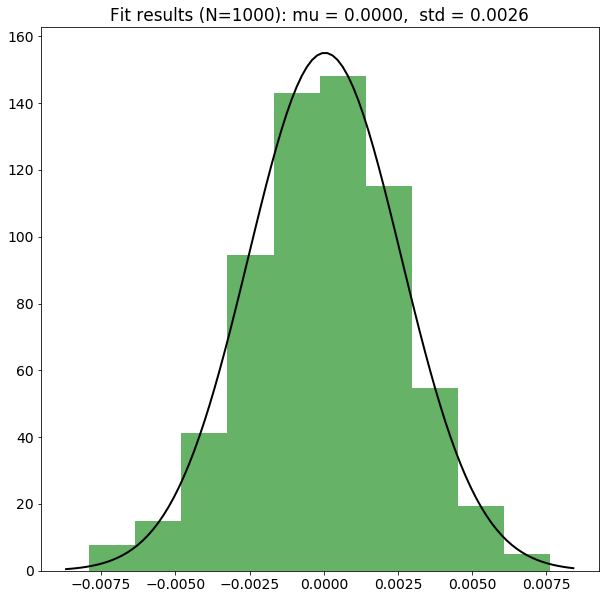

In [19]:
plot_covar_histo(1000)

For a particular sample size, generate a set of samples, and look to see how the covar distribution looks.

In [20]:
def calc_covar_for_sample(nSample):
    l = np.array([np.cov(generate(int(nSample)), rowvar=False)[0,1] for i in range(1000)])
    mu, std = norm.fit(l)
    return std

In [21]:
covar_from_samples =  pd.DataFrame(
    np.array([[ns, calc_covar_for_sample(ns)] for ns in  np.logspace(np.log10(20), 5, 20)]),
    columns=['nSample', 'Covar'])

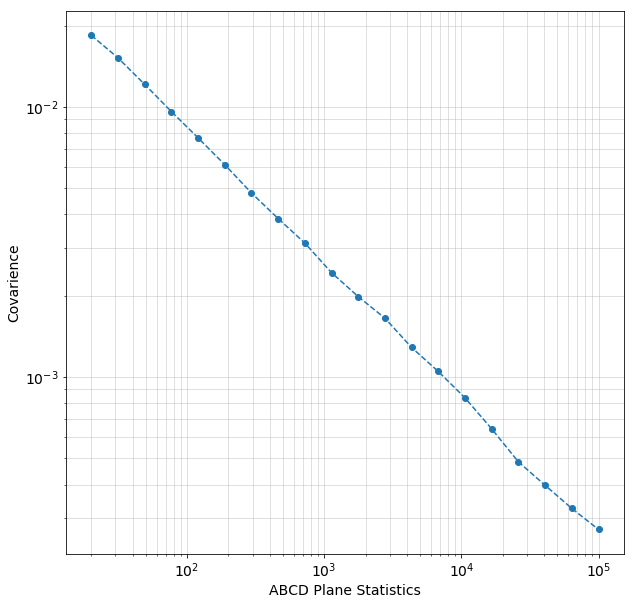

In [22]:
plt.figure(figsize=(10,10))
plt.loglog(covar_from_samples.nSample, covar_from_samples.Covar, 'o--')
plt.xlabel("ABCD Plane Statistics")
plt.ylabel("Covarience")
plt.grid(alpha=0.5, which='both')

How does the prediction vary with the covariance value for a particular sample size?

In [23]:
def plot_covar_pred(nSize):
    data = pd.DataFrame(np.array([[np.cov(sample, rowvar=False)[0,1], calc_ABCD(sample, xcut, ycut)] 
             for sample in [generate(nSize) for i in range(1000)]]),
             columns=['covar', 'predError'])
    plt.figure(figsize=(10,10))
    plt.plot(data.covar, data.predError, '.', c='lightgrey');
    plt.xlabel("Sample Covarience")
    plt.ylabel("Fractional Prediction Error")
    plt.title("Prediction Error as a function of Sample Covarience (N={0})".format(nSize))
    plt.axvline(0.0, c='blue')
    plt.axhline(0.0, c='blue');

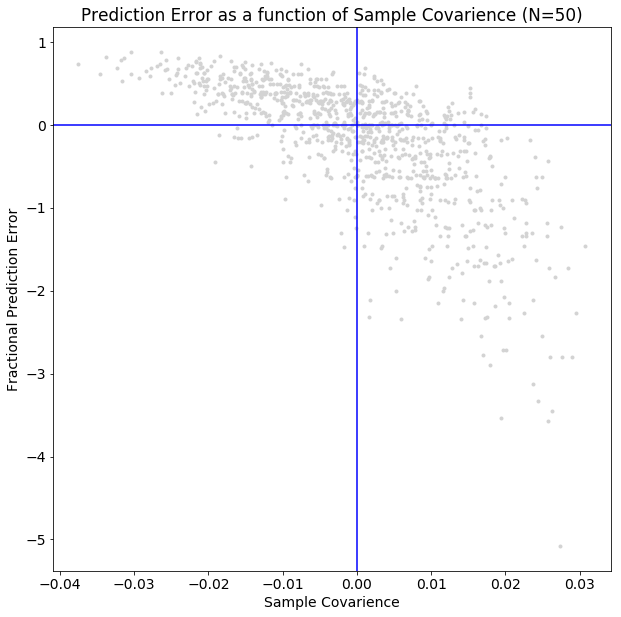

In [25]:
plot_covar_pred(50)

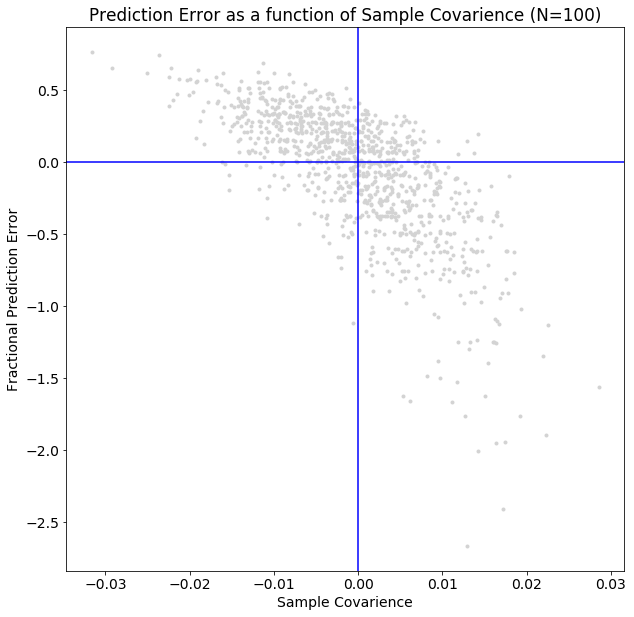

In [26]:
plot_covar_pred(100)

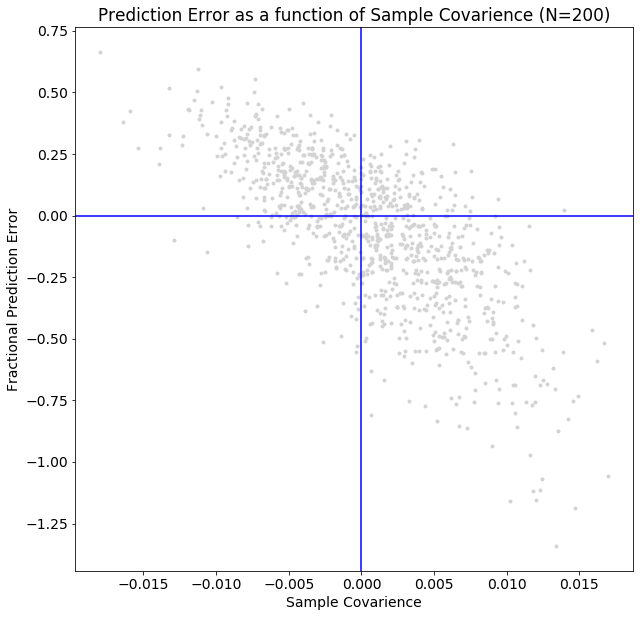

In [27]:
plot_covar_pred(200)

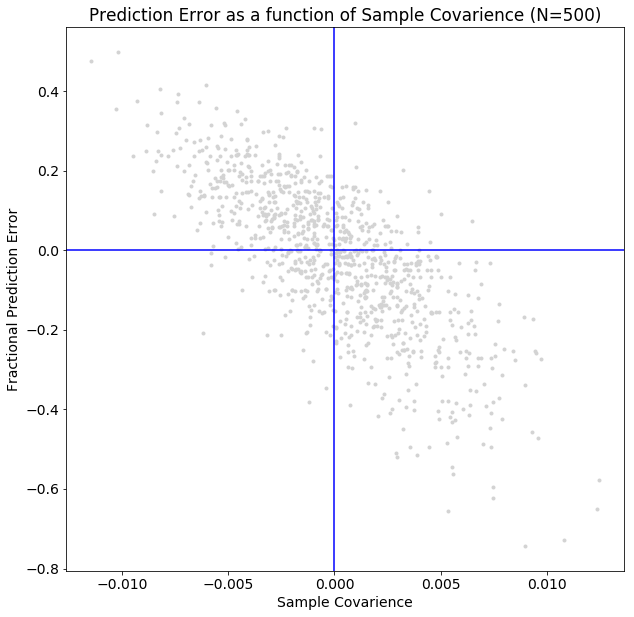

In [28]:
plot_covar_pred(500)

# Acknowledgements
Thanks to Toby Burnett for helping me make this code... better. :-)